In [3]:
import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,MinMaxScaler,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer
from sklearn import set_config

In [4]:
df = sns.load_dataset("titanic")

In [5]:
type(df)

pandas.core.frame.DataFrame

In [6]:
df.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Performing EDA

In [7]:
df.drop(columns=['who','adult_male','class','deck','embark_town','alone'],inplace = True)

In [8]:
df.sample(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,alive
435,1,1,female,14.0,1,2,120.0000,S,yes
584,0,3,male,NaN,0,0,8.7125,C,no
429,1,3,male,32.0,0,0,8.0500,S,yes


In [9]:
df['embarked'].value_counts(normalize=True)*100


embarked
S    72.440945
C    18.897638
Q     8.661417
Name: proportion, dtype: float64

In [10]:
df['sex'].value_counts(normalize=True)

sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64

In [11]:
df['family'] = df['sibsp'] + df['parch']

In [12]:
df.drop(columns=['sibsp','parch'],inplace=True)

In [13]:
df

,survived,pclass,sex,age,fare,embarked,alive,family
0,0,3,male,22.0,7.2500,S,no,1
1,1,1,female,38.0,71.2833,C,yes,1
2,1,3,female,26.0,7.9250,S,yes,0
3,1,1,female,35.0,53.1000,S,yes,1
4,0,3,male,35.0,8.0500,S,no,0
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,no,0
887,1,1,female,19.0,30.0000,S,yes,0
888,0,3,female,NaN,23.4500,S,no,3
889,1,1,male,26.0,30.0000,C,yes,0


In [14]:
df.head()

,survived,pclass,sex,age,fare,embarked,alive,family
0,0,3,male,22.0,7.2500,S,no,1
1,1,1,female,38.0,71.2833,C,yes,1
2,1,3,female,26.0,7.9250,S,yes,0
3,1,1,female,35.0,53.1000,S,yes,1
4,0,3,male,35.0,8.0500,S,no,0


In [15]:
df['alive'] = df['alive'].apply(lambda x : 1 if x == "yes" else 0)

In [16]:
df.isnull().sum()

survived      0
pclass        0
sex           0
age         177
fare          0
embarked      2
alive         0
family        0
dtype: int64

In [17]:
df.head()

,survived,pclass,sex,age,fare,embarked,alive,family
0,0,3,male,22.0,7.2500,S,0,1
1,1,1,female,38.0,71.2833,C,1,1
2,1,3,female,26.0,7.9250,S,1,0
3,1,1,female,35.0,53.1000,S,1,1
4,0,3,male,35.0,8.0500,S,0,0


<Axes: xlabel='survived', ylabel='count'>

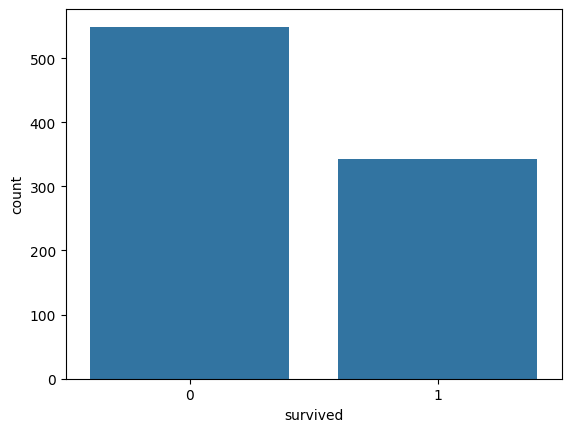

In [18]:
sns.countplot(x='survived',data=df)

<Axes: xlabel='embarked', ylabel='count'>

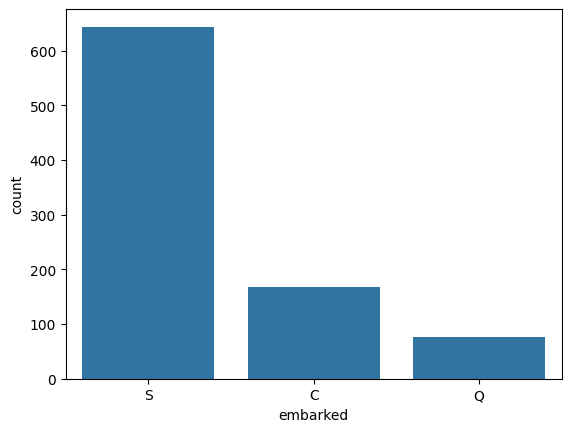

In [19]:
sns.countplot(x='embarked',data=df)

<Axes: ylabel='age'>

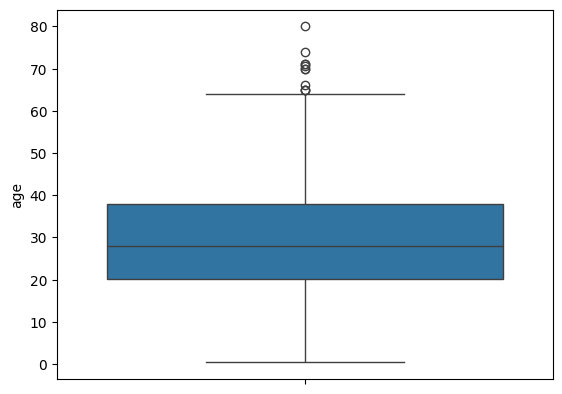

In [20]:
sns.boxplot(data=df ,y='age')

In [21]:
columns = df.columns.to_list()

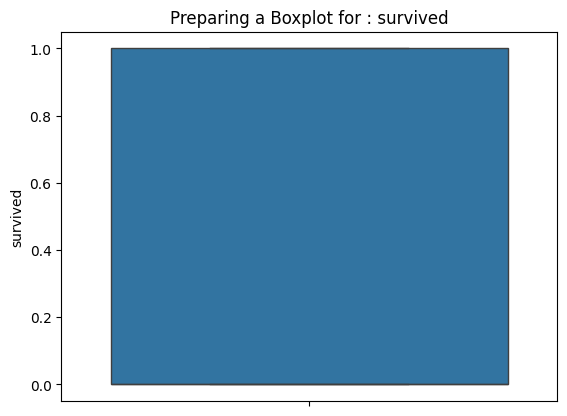

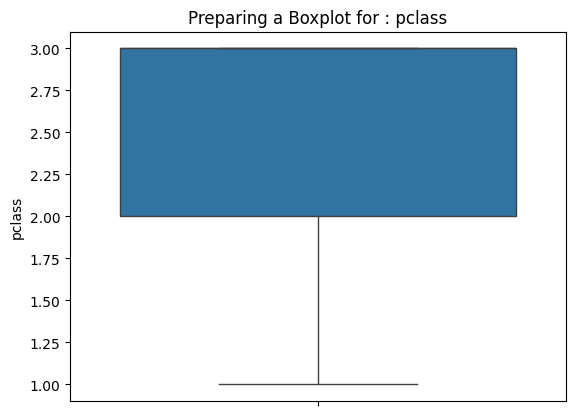

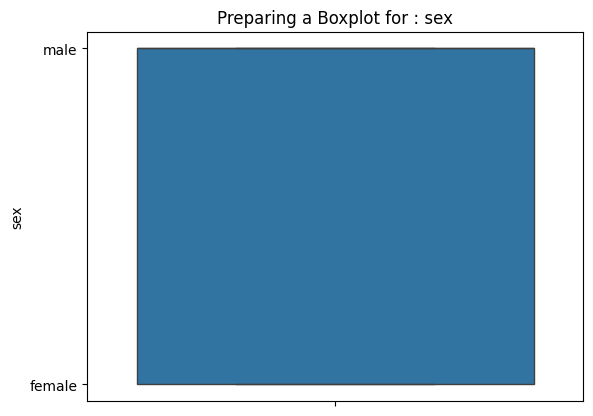

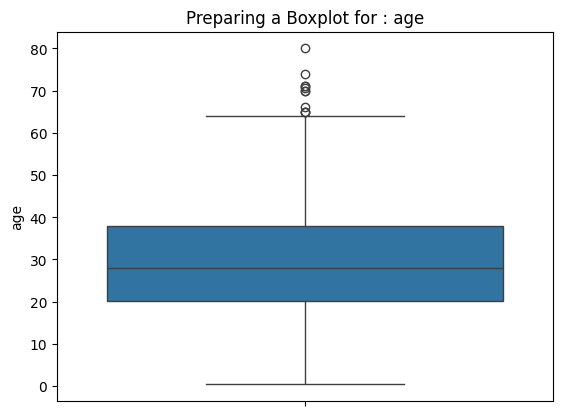

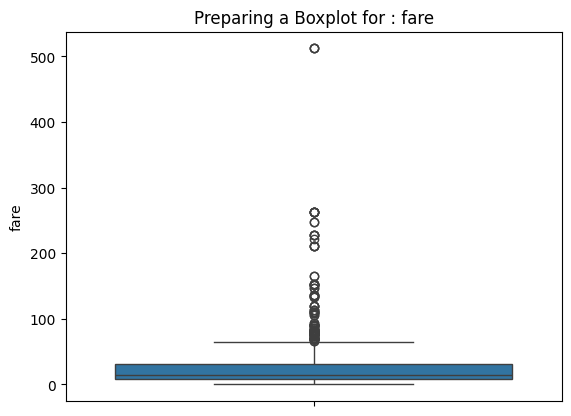

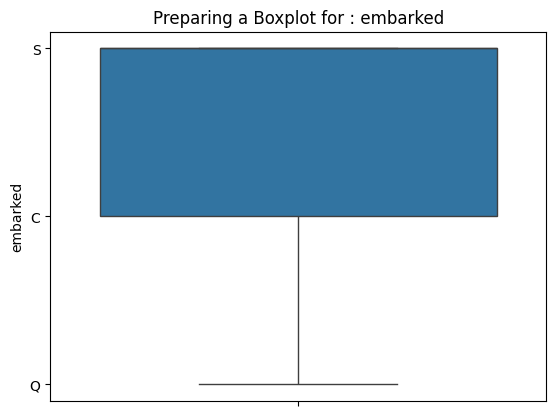

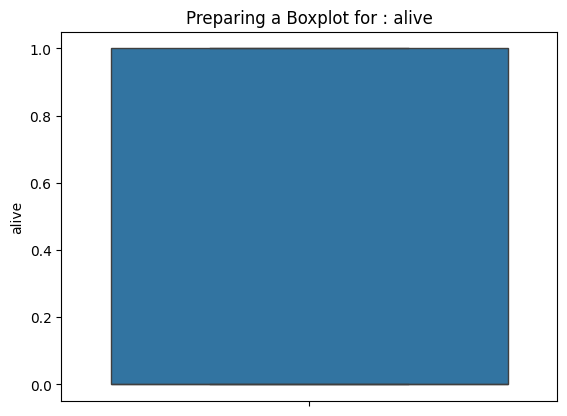

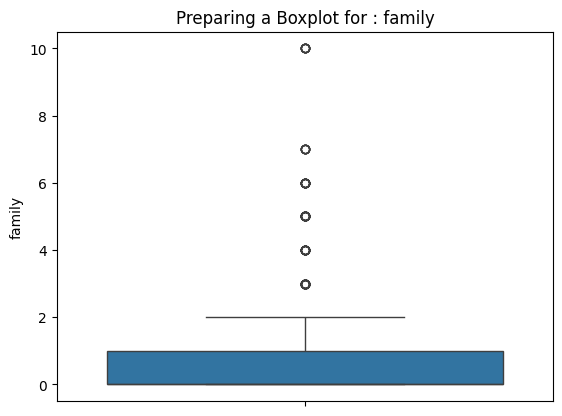

In [22]:
for col in columns :
    plt.title(f"Preparing a Boxplot for : {col}")
    sns.boxplot(data = df, y =col)
    plt.show()

Applying Transaformtions

In [23]:
set_config(transform_output='pandas')

In [24]:
df.columns

Index(['survived', 'pclass', 'sex', 'age', 'fare', 'embarked', 'alive',
       'family'],
      dtype='object')

In [25]:
df['age'].isnull().sum()

177

In [26]:
# age column
# pipeline banana hai

age_pipe = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('outliers',Winsorizer(capping_method='gaussian',fold=3)),
    ('scaling' , StandardScaler())
])

In [27]:
# fare pipeline

fare_pipe = Pipeline(steps=[
    ('outliers',Winsorizer(capping_method='iqr',fold=1.5)),
    ('scale',StandardScaler())
])

fare_pipe

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [28]:
# embarked_pipeline

embarked_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('count_encode',CountFrequencyEncoder(encoding_method='count')),
    ('scale',MinMaxScaler())
])

embarked_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

Dividing the Data

In [29]:
df.head(5)

,survived,pclass,sex,age,fare,embarked,alive,family
0,0,3,male,22.0,7.2500,S,0,1
1,1,1,female,38.0,71.2833,C,1,1
2,1,3,female,26.0,7.9250,S,1,0
3,1,1,female,35.0,53.1000,S,1,1
4,0,3,male,35.0,8.0500,S,0,0


In [30]:
X = df.drop(columns=['survived'])
y = df['survived']

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [32]:
X_train.shape

(712, 7)

In [33]:
y_train.shape

(712,)

# Column Transformer

In [34]:
preprocessor = ColumnTransformer(transformers=[
    ('age',age_pipe,['age']),
    ('fare',fare_pipe,['fare']),
    ('embarked',embarked_pipe,['embarked']),
    ('sex',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['sex']),
    ('family',MinMaxScaler(),['family'])
],remainder='passthrough',n_jobs=-1,force_int_remainder_cols=False)

preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('outliers',
                                                  Winsorizer(fold=3)),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('outliers',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('count_encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [35]:
preprocessor.fit_transform(X_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass,remainder__alive
331,1.266850,0.236751,1.0,0.0,1.0,0.0,1,0
733,-0.478777,-0.532339,1.0,0.0,1.0,0.0,2,0
382,0.219474,-0.784153,1.0,0.0,1.0,0.0,3,0
704,-0.246027,-0.787666,1.0,0.0,1.0,0.1,3,0
813,-1.797695,0.374443,1.0,1.0,0.0,0.6,3,0
...,...,...,...,...,...,...,...,...
106,-0.633944,-0.797799,1.0,1.0,0.0,0.0,3,1
270,-0.090860,0.360798,1.0,0.0,1.0,0.0,1,0
860,0.917724,-0.477346,1.0,0.0,1.0,0.2,3,0
435,-1.177028,2.016201,1.0,1.0,0.0,0.3,1,1


In [36]:
y_train

331    0
733    0
382    0
704    0
813    0
      ..
106    1
270    0
860    0
435    1
102    0
Name: survived, Length: 712, dtype: int64

In [37]:
preprocessor.get_params()

{'force_int_remainder_cols': False,
 'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                   ('outliers', Winsorizer(fold=3)),
                   ('scaling', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('outliers', W

# Model Training

In [38]:
rf_model = RandomForestClassifier()

In [39]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [40]:
# build the model pipeline

model_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

In [41]:
rf_model.set_params(**model_params)

RandomForestClassifier(max_depth=6, max_samples=0.8, n_estimators=300,
                       n_jobs=-1, random_state=30)

In [42]:
model_pipe = Pipeline(
    steps=[
        ('preprocessor',preprocessor),
        ('model',rf_model)
    ]
)

In [43]:
model_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('model',
                 RandomForestClassifier(max_depth=6, max_samples=0.8,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=30))])

In [44]:
y_pred = model_pipe.predict(X_test)

In [45]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred).item()
recall = recall_score(y_test,y_pred).item()
f1 = f1_score(y_test,y_pred).item()

In [46]:
metrics = {
    'accuracy':accuracy,
    'precision':precision,
    'recall':recall,
    'f1_score':f1
}

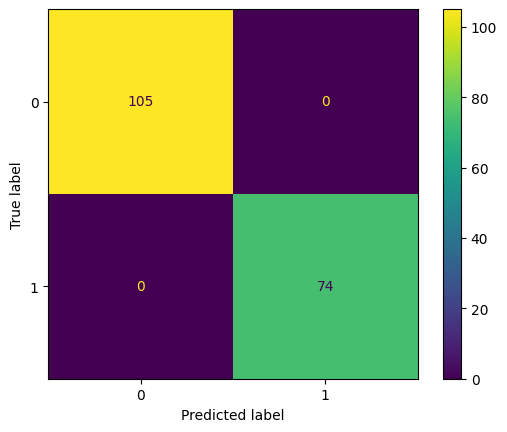

In [47]:
cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

# MLFLOW Begins

In [48]:
mlflow.is_tracking_uri_set()

True

In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Titanic Model Tracker")

with mlflow.start_run(run_name="Fourth Run") as run :
    data_signature = mlflow.models.infer_signature(model_input=X_train,model_output=model_pipe.predict(X_train))
    # signature = It is used for defining the input and output schema of the model.
    mlflow.log_params(model_pipe.get_params())
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="model",
        signature=data_signature
    )

    model_uri = f"runs:/{run.info.run_id}/model"

c:\Users\avanindra Bose\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/01/17 01:09:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Fourth Run at: http://127.0.0.1:5000/#/experiments/1/runs/75ae891dee0544d1a82a162b9a8c5ee0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


: 